In [26]:
import os
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
# Some Basic Directories for housekeeping
# set location of input files:
inpDir = os.path.join( '..', 'input')

outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

CMAP = plt.cm.rainbow
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

# Define constants for data manipulation
TEST_SIZE = 0.2
NOISE = 0.2
N_SAMPLE = 1024

<Figure size 640x480 with 0 Axes>

In [3]:
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',    
          'figure.figsize': (15, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 75,
          'image.cmap': 'summer',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }


plt.rcParams.update(params)

'''plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))
'''
np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

In [4]:
data_df=pd.read_csv(os.path.join(inpDir, 'quarterly-beer-production-in-aus-March 1956-June 1994.csv'))
data_df

,Quarter,Quarterly beer production in Australia: megalitres. March 1956 ? June 1994
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0
...,...,...
149,1993Q2,420.0
150,1993Q3,411.0
151,1993Q4,512.0
152,1994Q1,449.0


In [5]:
data_df.head(12)

,Quarter,Quarterly beer production in Australia: megalitres. March 1956 ? June 1994
0,1956Q1,284.4
1,1956Q2,212.8
2,1956Q3,226.9
3,1956Q4,308.4
4,1957Q1,262.0
5,1957Q2,227.9
6,1957Q3,236.1
7,1957Q4,320.4
8,1958Q1,271.9
9,1958Q2,232.8


In [6]:
data_df.describe()

,Quarterly beer production in Australia: megalitres. March 1956 ? June 1994
count,154.00
mean,408.27
std,97.60
min,212.80
25%,325.42
50%,427.45
75%,466.95
max,600.00


In [7]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Quarter                                                                     154 non-null    object 
 1   Quarterly beer production in Australia: megalitres. March 1956 ? June 1994  154 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [8]:
data_df.isnull().sum()

Quarter                                                                       0
Quarterly beer production in Australia: megalitres. March 1956 ? June 1994    0
dtype: int64

In [9]:
def fn_quarter_to_datetime(quarter_str):
    year,quarter = quarter_str.split('Q')
    month = np.int16(quarter)*3-2
    return pd.to_datetime(f"{year}-{month:02d}")

data_df['date']=data_df['Quarter'].apply(fn_quarter_to_datetime)
data_df.head()

,Quarter,Quarterly beer production in Australia: megalitres. March 1956 ? June 1994,date
0,1956Q1,284.4,1956-01-01
1,1956Q2,212.8,1956-04-01
2,1956Q3,226.9,1956-07-01
3,1956Q4,308.4,1956-10-01
4,1957Q1,262.0,1957-01-01


In [10]:
data_df['date'].dt.year.unique()


array([1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966,
       1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977,
       1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994])

In [11]:
data_df.columns = ['quarter','production','date']

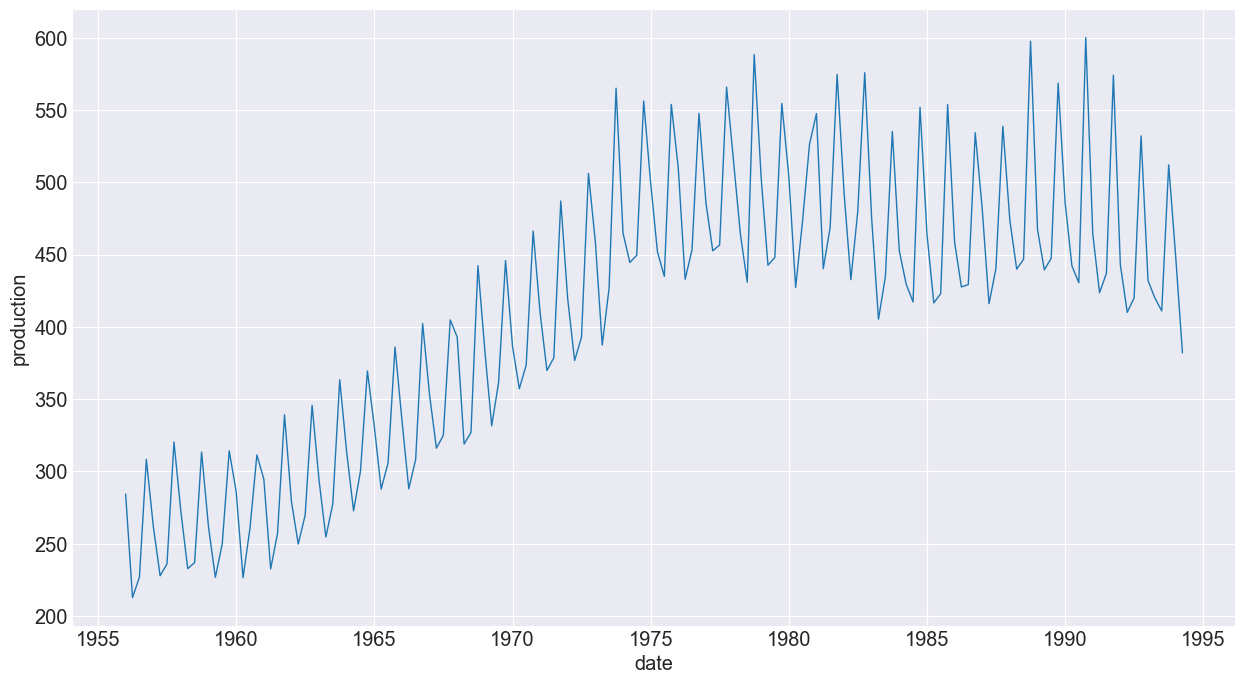

In [12]:
sns.lineplot(x=data_df['date'],y=data_df['production'])
plt.show()

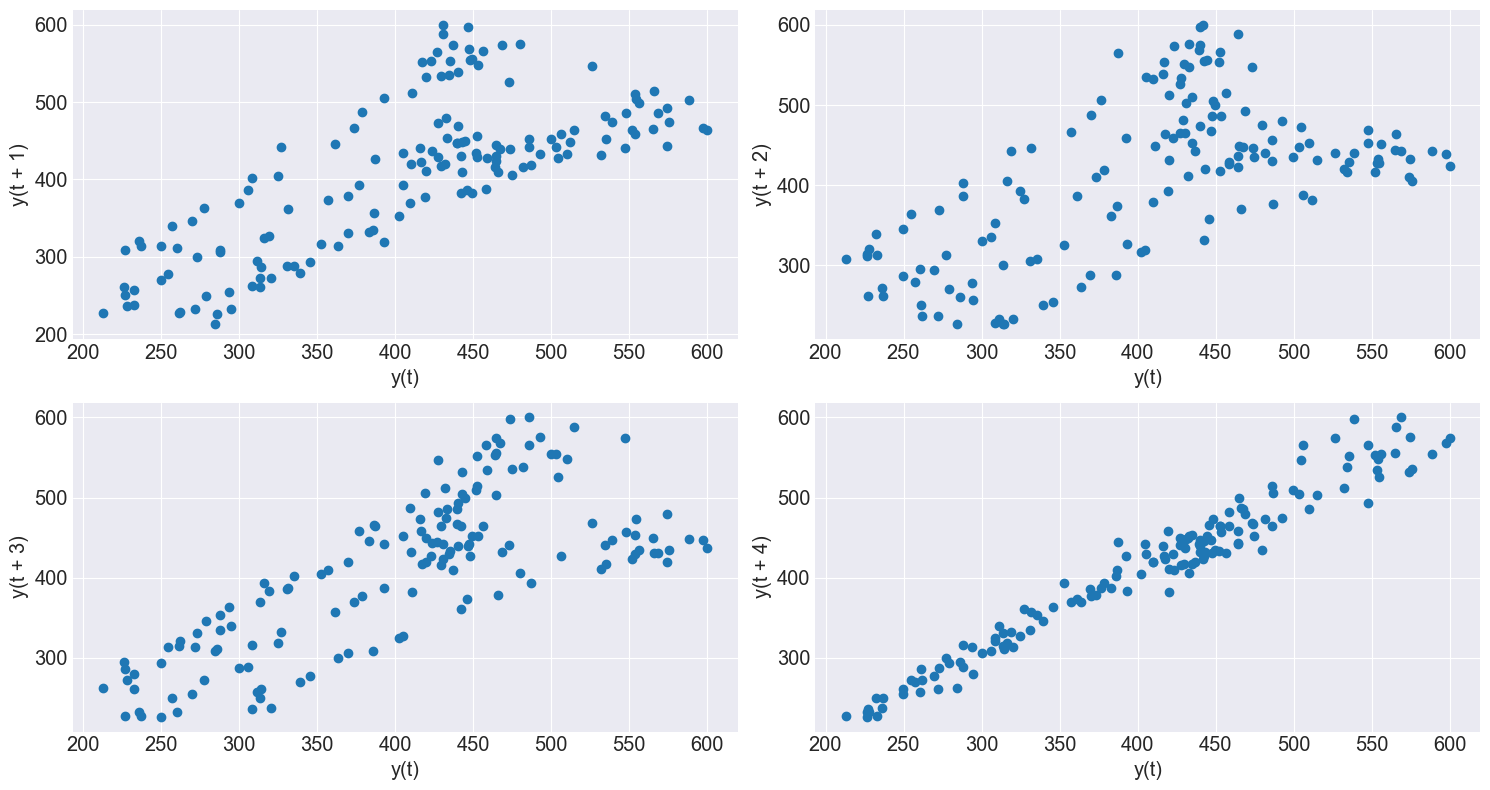

In [13]:
fig,axes=plt.subplots(ncols=2,nrows=2,figsize=(15,8))
for count, ax in enumerate(axes.ravel()):
    pd.plotting.lag_plot(data_df['production'],lag = count+1,ax=ax);
plt.tight_layout()

In [14]:
def get_trend(timeseries,deg=3):
    '''
    Arg:
        timeseries: pandas series cotaining values from the ts
        deg: degree of polynomial to fit
    Return: 
        pandas series containing trend (fitted curve)
    '''
    x=list(range(len(timeseries)))
    
    y=timeseries.values
    
    coef=np.polyfit(x,y,deg)
    
    trend=np.poly1d(coef)(x)
    
    return pd.Series(data = trend, index = timeseries.index)
data_df['Trend'] = get_trend(data_df['production'])
data_df.head()

,quarter,production,date,Trend
0,1956Q1,284.4,1956-01-01,232.01
1,1956Q2,212.8,1956-04-01,234.32
2,1956Q3,226.9,1956-07-01,236.68
3,1956Q4,308.4,1956-10-01,239.08
4,1957Q1,262.0,1957-01-01,241.51


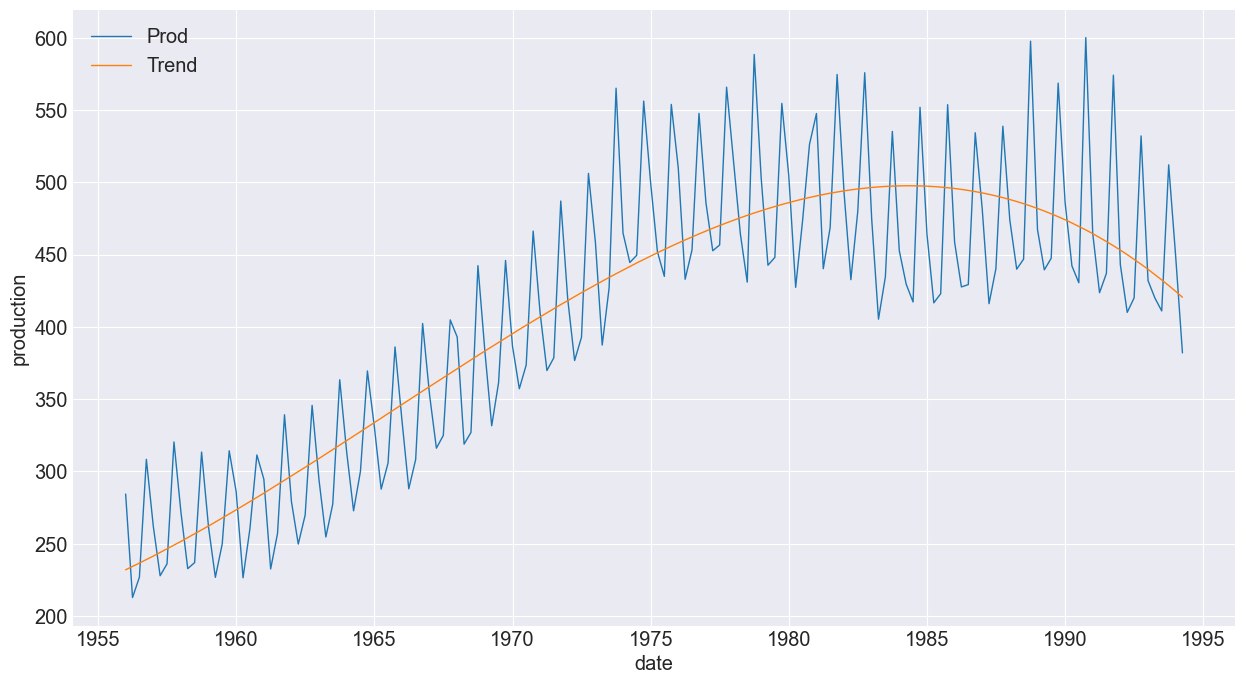

In [15]:
plt.figure()
sns.lineplot(x = data_df['date'], y = data_df['production'], label = 'Prod')
sns.lineplot(x = data_df['date'], y = data_df['Trend'], label = 'Trend')
plt.legend();

In [16]:
data_df['year'] = data_df['date'].dt.year
data_df.head()

,quarter,production,date,Trend,year
0,1956Q1,284.4,1956-01-01,232.01,1956
1,1956Q2,212.8,1956-04-01,234.32,1956
2,1956Q3,226.9,1956-07-01,236.68,1956
3,1956Q4,308.4,1956-10-01,239.08,1956
4,1957Q1,262.0,1957-01-01,241.51,1957


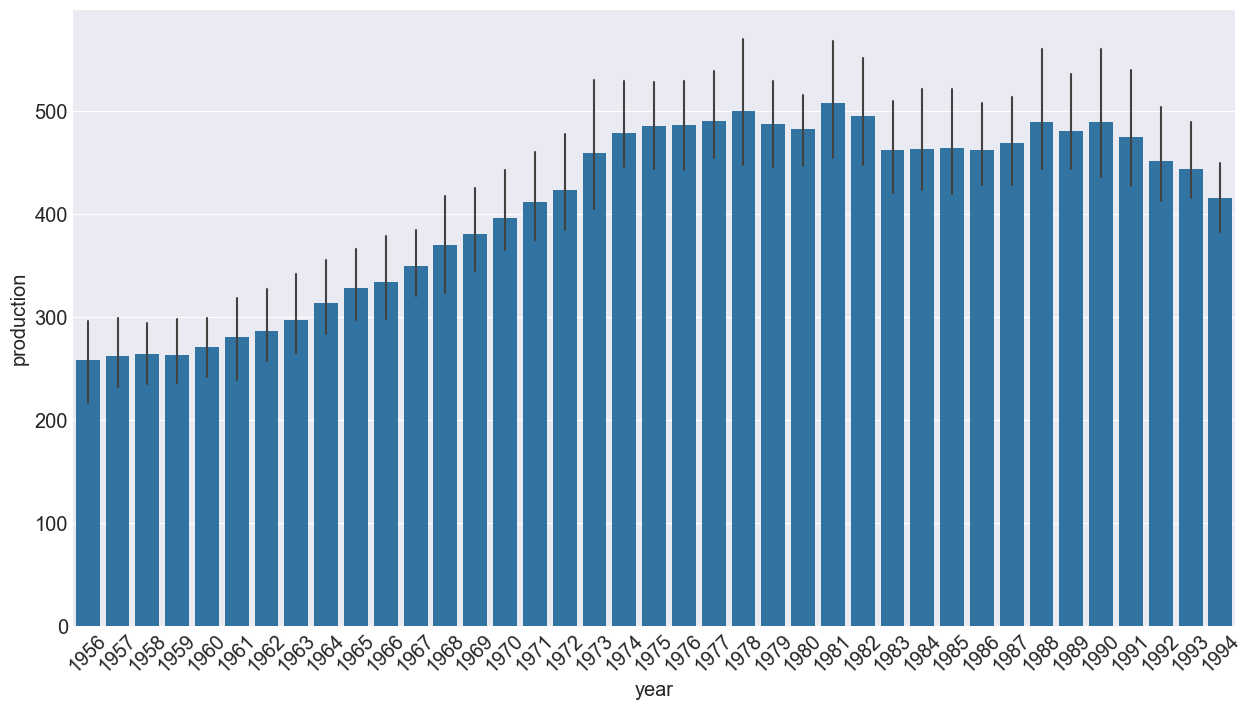

In [17]:
plt.figure()

ax = sns.barplot(data = data_df, x = 'year', y = 'production')

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

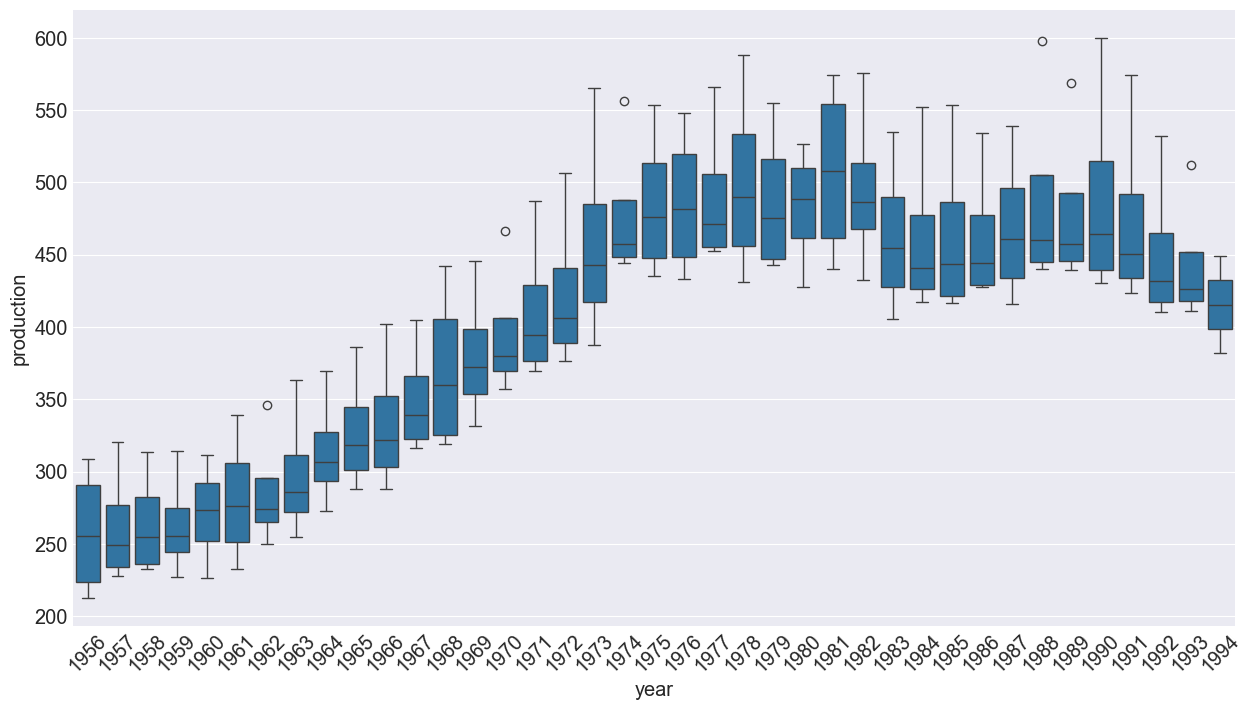

In [18]:
ax = sns.boxplot (data = data_df, x = 'year', y = 'production')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [19]:
decomposition = sm.tsa.seasonal_decompose(data_df['production'],model='additive',period = 4)

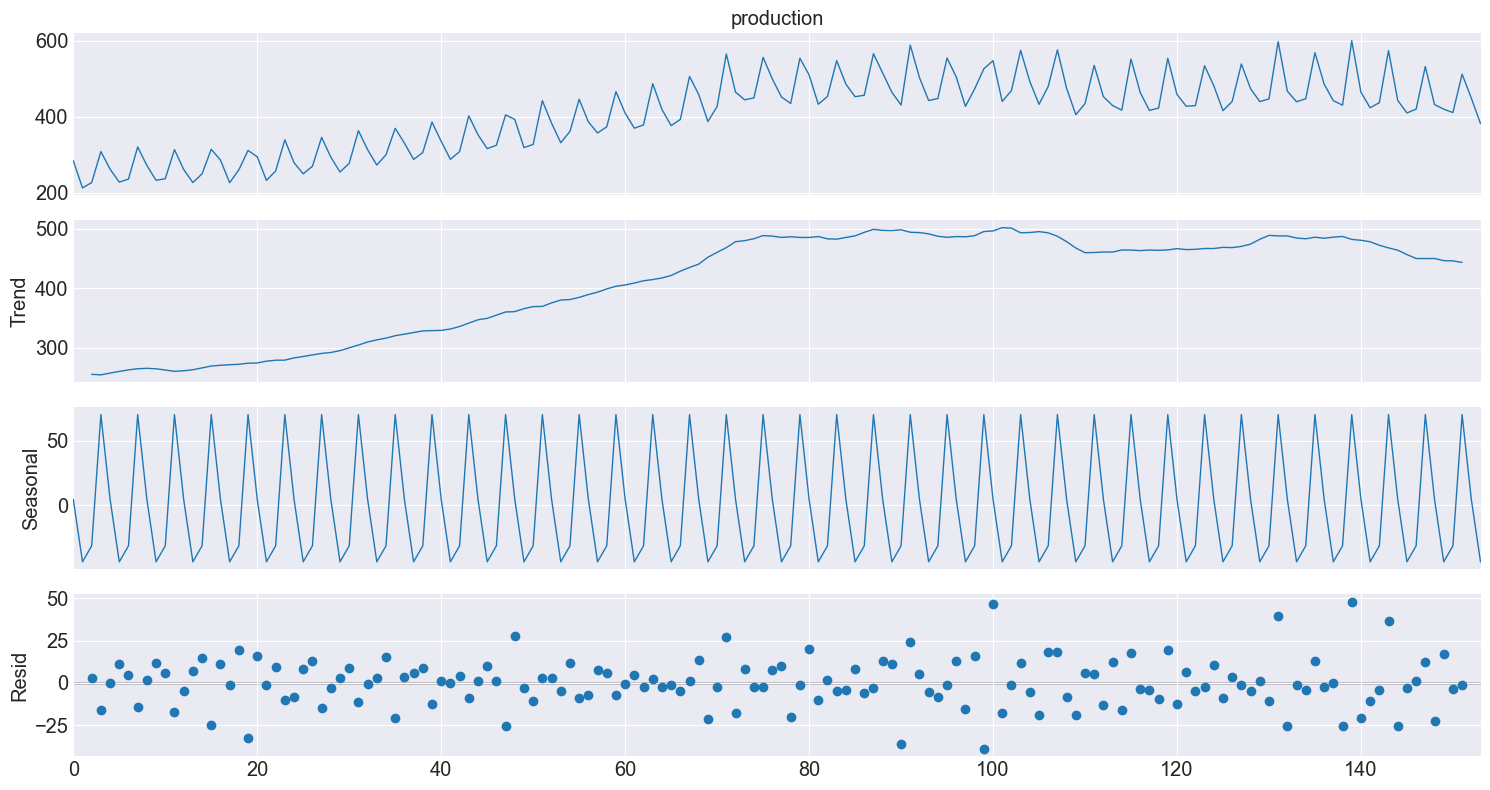

In [20]:
fig = decomposition.plot()

In [21]:
feature_df = data_df[['production']].copy()

feature_df.columns = ['T_i']

feature_df['T_(i-1)'] = feature_df['T_i'].shift(1)

feature_df['T_(i-2)'] = feature_df['T_i'].shift(2)

feature_df = feature_df.drop(feature_df.index[[0,1]])

feature_df.head()

,T_i,T_(i-1),T_(i-2)
2,226.9,212.8,284.4
3,308.4,226.9,212.8
4,262.0,308.4,226.9
5,227.9,262.0,308.4
6,236.1,227.9,262.0


In [22]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

X = feature_df[['T_(i-1)']]

y = feature_df['T_i']

model = reg.fit(X,y)

feature_df['predicted_T_i|i_(i-1)'] = reg.predict(X)

#How much residual

feature_df['residual_T_i|i_(i-1)'] = feature_df['T_i'] - feature_df['predicted_T_i|i_(i-1)']

feature_df.head()

,T_i,T_(i-1),T_(i-2),predicted_T_i|i_(i-1),residual_T_i|i_(i-1)
2,226.9,212.8,284.4,266.57,-39.67
3,308.4,226.9,212.8,276.89,31.51
4,262.0,308.4,226.9,336.55,-74.55
5,227.9,262.0,308.4,302.58,-74.68
6,236.1,227.9,262.0,277.62,-41.52


In [23]:
# For lag of 2

reg = LinearRegression()

X = feature_df[['T_(i-1)']]

y = feature_df['T_(i-2)']

model = reg.fit(X,y)

feature_df['predicted_T_(i-2)|T_(i-1)'] = reg.predict(X)

#How much residual

feature_df['residual_T_(i-2)|T_(i-1)'] = feature_df['T_(i-2)'] - feature_df['predicted_T_(i-2)|T_(i-1)']

feature_df.head()

,T_i,T_(i-1),T_(i-2),predicted_T_i|i_(i-1),residual_T_i|i_(i-1),predicted_T_(i-2)|T_(i-1),residual_T_(i-2)|T_(i-1)
2,226.9,212.8,284.4,266.57,-39.67,260.88,23.52
3,308.4,226.9,212.8,276.89,31.51,271.45,-58.65
4,262.0,308.4,226.9,336.55,-74.55,332.56,-105.66
5,227.9,262.0,308.4,302.58,-74.68,297.77,10.63
6,236.1,227.9,262.0,277.62,-41.52,272.20,-10.20


In [24]:
feature_df.corr(method = 'pearson')['residual_T_i|i_(i-1)']['residual_T_(i-2)|T_(i-1)']

0.09923963983280493

### Calculate ACF

In [27]:
acf(feature_df['T_i'], nlags = 1)

array([1.   , 0.726])

In [29]:
acf(feature_df['T_i'], nlags = 2)

array([1.   , 0.726, 0.578])

### Calculate PACF

In [30]:
pacf(feature_df['T_i'], nlags = 1)

array([1.   , 0.731])

In [31]:
pacf(feature_df['T_i'], nlags = 2)

array([1.   , 0.731, 0.111])

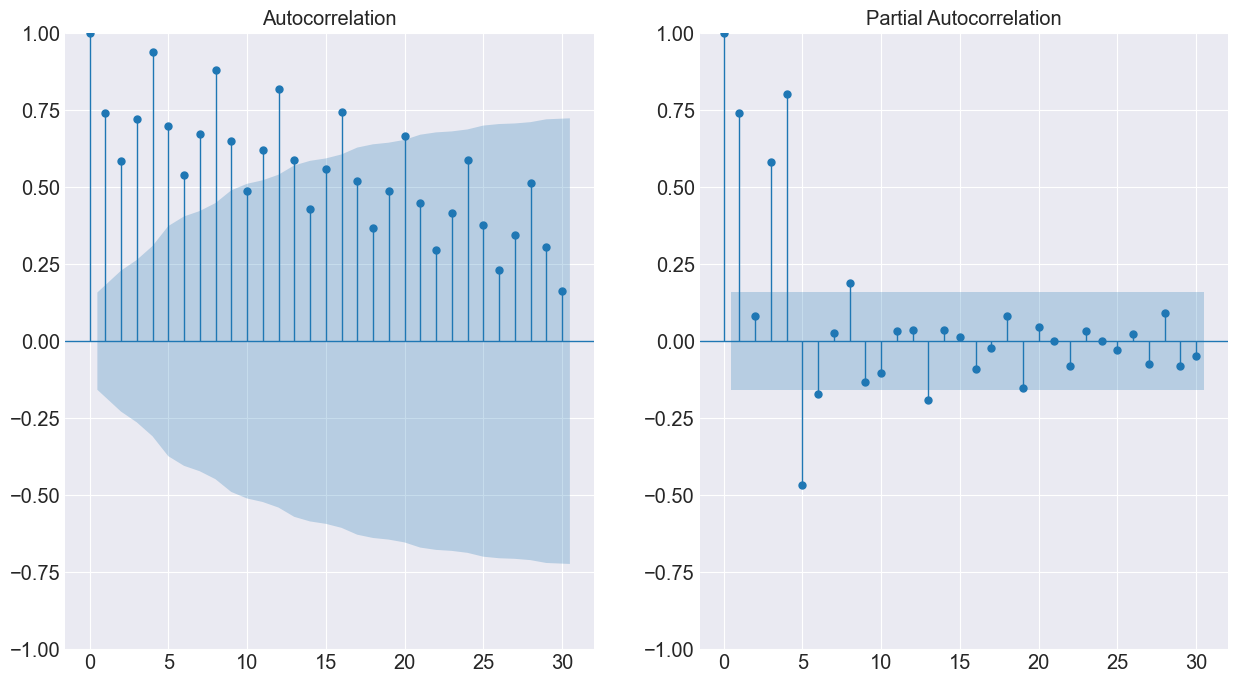

In [32]:
fig, ax = plt.subplots(1,2)

_ = plot_acf(data_df['production'], lags = 30, ax = ax[0])
_ = plot_pacf(data_df['production'], lags = 30, ax = ax[1])